# Predicting Successful Transactions

In this task we are interested in aiming to predict whether a transaction is likely to be successful. Given the data being at the transaction level, I took the approach that we are primarily interested in scoring transactions as they come in.

*As an aside; given more time and a better understanding of the data & business case, I would be interested in examining how we may be able to improve the recall of this approach by rescoring transactions at certain intervals (Initiated, Authorised, Executing). My thinking is that the business may be more interested in detecting potential payment failure earlier in the process, perhaps to hold out on immediat/upfront settlement, in which case it would be less beneficial to rescore. Additionally, there is the resource cost implication, but still it would be an interesting piece of analysis.*


The chosen approach to the problem has a implications for the data fields we could utilise within this set.

- Timestamp features are unhelpful in predicting this problem, as we would not have meaningful data at inception of a transaction for these fields. Notwithstanding data sparsity/integrity for these fields.
- Failure stage is not helpful for prediction as this information is not present at inception.
- Failure Reason is interesting from a process point of view, and understanding why we may see failed transactions, though is unable to be used for prediction as obviously it is also not present at inception - we learn this post failure.
- Lastly 'id' being the transaction identifier, obviously isn't considered for prediction.

This leaves us with the following raw data we can leverage for prediction:
- bank_id
- currency
- api_version
- vertical
- connectivity_type
- amount_in_currency
- country_id
- customer_id

Given the lack of data dictionary with this task, I was limited in my understanding of how to engineer features manually to enhance their predictive power. Though certain generic steps were taken to make life a bit easier for the model!

Nulls were spotted in the API version & Vertical fields, these were associated with authorization failures probably due to technical problems with API calls. The choice was made to omit these rows as while they are associated with payment failure, they could be easily detected without need for a ML solution if my assumpmtions hold true.

The customer_id field was also cleaned to wrap id's with less than 100 obeservations in the data to a new category 'rare_customer'. This is to make the process of encoding these categories in the model a little more robust.

### Model

The model I chose to use was a CatBoost classifier. This model natively handles categorical features in their string format and encodes them using ordered target based encoding. As we have high cardinality in the categorical features 'bank_id' & 'customer_id', this was ideal for our problem, as we lack the ability to use One Hot encoding (the curse of dimensionality). In addition to this CatBoost leverages the performative capabilities of gradient boosting models, performs well with relatively little hyperparameter tuning and can be trained quickly on GPU. The target for the classifier was created as a binary feature 'target' - 1 if payment was executed else 0. The problem statement asks if we can predict the likelihood of a payment being successful, the ouput score of a classifier model can tell us this.

The model was trained using a small hyperparameter sweep for tuning and 4 cv folds to mitigate overfitting.

### Results

The model displays no evidence of overfit, demonstrated by the similarity in training and testing metrics which is positive. In brief the model predicts the majority class well, which is what we tend to experience in datasets with moderate class imbalance such as this. What we are more interested in is it's ability to detect the minority class, in this case payment failures. The model with default classification threshold of .5 achieves recall of .17 on the negative class i.e. correctly identifies 17% of all payment failures, with a precision of .65 i.e. 65% of predicted failures are true failures. Threshold adjustment will allow the business stakeholders to select a desired level of precision - by increasing the threshold we will see precision increase at the expense of recall, and vice versa. If we want to capture more true failures we could adjust the threshold downwards, but we would see more false negatives.

The aim of this model as outlined in the brief was to assess how likely a payment was to be successful. Looking at the calibration curve on the test set, we can see that the model performs pretty well in this task, with the results being w=very close to perfect calibration across all deciles. This means we can trust the probability scores output from this calssifier as a decent proxy for likelihood of success.

### Deployment

I would envision this model being deployed for online prediction, with each transaction being scored as it is initiated. I invision this being used to put a hold on advanced payment of transactions with a low likelihood of success. For this to be achieved, we need a very low latency architecture, as payments usually settle/fail within seconds of being initiated.

In terms of how this is achieved, we would need to work with engineering teams to develop streamlined ETL payloads and microservices for model orchestration with this as the goal. Model serialization could be optimised with speed of inference in mind. In addition, we would want to experiment with various AWS EC2 instance specifications to strike a balance between performance and cost of inference.

### Import Dependencies

In [1]:
!pip install pandas numpy seaborn
!pip install catboost

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.calibration import calibration_curve

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Data & EDA

In [2]:
df = pd.read_csv('/content/drive/MyDrive/truelayer/truelayer_data_sc_test_data_set.csv')

In [3]:
# Basic info
print(df.info())
print(df.describe())

# Counts for categorical features
for column in df.select_dtypes(include=['object']):
  print(f"\nCounts for {column}:")
  print(df[column].value_counts())


Streaming output truncated to the last 5000 lines.
2009-08-17 22:11:32.092516    1
2009-12-29 02:11:38.713000    1
2009-11-20 09:08:54.487000    1
2009-08-11 17:51:20.609326    1
2009-12-18 20:13:45.370000    1
2009-12-03 15:53:28.480000    1
2009-11-07 08:06:50.300000    1
2009-03-06 18:23:38.049359    1
2010-01-22 19:02:31.077000    1
2009-12-13 19:56:21.357000    1
2009-12-31 17:26:48.727000    1
2010-02-05 11:26:43.217000    1
2009-12-07 21:15:41.440000    1
2009-12-02 08:54:39.183000    1
2010-02-04 00:03:29.720000    1
2010-01-03 21:10:41.830000    1
2009-12-06 21:37:31.050000    1
2010-02-02 19:25:14.123000    1
2010-01-22 13:01:23.597000    1
2010-01-18 09:17:03.523000    1
2008-08-11 19:23:54.260128    1
2010-01-30 15:49:22.300000    1
2009-11-19 22:22:52.220000    1
2009-10-22 08:43:07.994981    1
2010-01-02 15:16:30.243000    1
2008-09-24 20:32:28.867362    1
2008-09-05 22:26:22.616302    1
2009-02-24 00:22:26.426616    1
2009-11-09 19:32:32.147000    1
2008-09-25 00:18:47.0

In [4]:
df.status.value_counts()

,count
status,
Executed,377616
failed,44621
Initiated,29474
Cancelled,18798
New,18791
initiated,4576
Rejected,4058
Executing,936
Failed,478


### Define Functions

In [5]:
def clean_up_data(input_df):
  df = input_df.copy()
  df['target'] = np.where(df['status'] == 'Executed', 1, 0)

  threshold = 100
  category_counts = df['customer_id'].value_counts()
  rare_categories = category_counts[category_counts < threshold].index

  df['customer_id_cleaned'] = df['customer_id'].replace(rare_categories, 'rare_customer')
  df = df[df['connectivity_type'].isna() == False]
  df = df[df['vertical'].isna() == False]

  non_features = ['status', 'customer_id', 'failure_reason', 'createdat_ts', 'lastupdatedat_ts',
       'initiated_at', 'executed_at', 'failure_stage', 'failure_reason', 'failed_at', 'authorizing_at',
       'authorized_at', 'settled_at']

  df = df.drop(non_features, axis=1)

  return df

def create_train_test(df):

  train, test = train_test_split(df, test_size = 0.2, stratify = df['target'])

  x_train = train.drop(columns=['target'], axis = 1)
  x_test = test.drop(columns=['target'], axis = 1)
  y_train = train['target']
  y_test = test['target']

  return x_train, y_train, x_test, y_test

def fit_catboost(x, y, param_grid, cv=4):

  cat_features = [
      'customer_id_cleaned',
      'connectivity_type',
      'vertical',
      'country_id',
      'currency',
      'api_version',
      'bank_id',
  ]

  catboost_classifier = CatBoostClassifier(
    task_type='GPU',
    objective='Logloss',
    eval_metric='F1',
    random_seed=42)

  grid_search = GridSearchCV(catboost_classifier, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
  grid_search.fit(x, y, cat_features=cat_features)
  best_model = grid_search.best_estimator_

  print('Best Hyperparameters:', grid_search.best_params_)
  print('Best Estimator:', best_model)

  return best_model

def evaluate_classifier(y_pred, y_true, y_pred_prob, class_labels=['Failure', 'Success']):

  count_pos = sum(y_true)
  count_neg = len(y_true) - count_pos

  prop_pos = count_pos / len(y_true)
  prop_neg = count_neg / len(y_true)

  majority_class = 1 if prop_pos > prop_neg else 0

  y_pred_nir = [majority_class] * len(y_true)
  nir = round(accuracy_score(y_true, y_pred_nir), 2)

  print(classification_report(y_true = y_true, y_pred = y_pred, target_names = class_labels))
  print('No Information Rate:', nir)

  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(class_labels))
  plt.xticks(tick_marks, class_labels, rotation = 45)
  plt.yticks(tick_marks, class_labels)

  thresh = cm.max() / 2
  tot = len(y_true)
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment = 'center',
               color = 'white' if cm[i, j] > thresh else 'black')

  plt.xlabel('Predicted label')
  plt.ylabel('True Label')
  plt.show()

  plt.figure(figsize = (8, 6))
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:,1])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label = 'AUC = %0.3f' % roc_auc)
  plt.plot([0, 1], [0, 1], color = 'gray', lw=2, linestyle = '--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Reciever Operator Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

  return

def score(x_train, x_test, model):

  train_pred = model.predict(x_train)
  train_pred_prob = model.predict_proba(x_train)
  test_pred = model.predict(x_test)
  test_pred_prob = model.predict_proba(x_test)

  return train_pred, train_pred_prob, test_pred, test_pred_prob



### Apply clean_up_data and train_test_split

In [6]:
clean_df = clean_up_data(df)
clean_df = clean_df.set_index('id')

In [7]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483683 entries, 3c6646ef17a52ac2e35fdb6a15aa44db6d85985b to 602219a84abf92b0a89c1480b83cba09659f6bcf
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bank_id              483683 non-null  object 
 1   currency             483683 non-null  object 
 2   api_version          483683 non-null  object 
 3   vertical             483683 non-null  object 
 4   connectivity_type    483683 non-null  object 
 5   amount_in_currency   483683 non-null  float64
 6   country_id           483683 non-null  object 
 7   target               483683 non-null  int64  
 8   customer_id_cleaned  483683 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 36.9+ MB


In [8]:
x_train, y_train, x_test, y_test = create_train_test(clean_df)


In [9]:
x_train.head()

,bank_id,currency,api_version,vertical,connectivity_type,amount_in_currency,country_id,customer_id_cleaned
id,,,,,,,,
60f9cde014ad52900aaaafa2d445d6589188f59f,fa485aff3f9e34d55d25f78856d4a2526a5f8e6f,CAD,v3,vertical 5,type 8,10.00,9e2b06736b477b7a924f60de14a7e329d82d6f4f,d292da2283043c07accb1086a004caaf05472d44
1273e7e673ad3831100c4503baf8beeed7395b54,fa485aff3f9e34d55d25f78856d4a2526a5f8e6f,CAD,v2,vertical 2,type 8,16.00,9e2b06736b477b7a924f60de14a7e329d82d6f4f,66d78f2bca1f8bd1602cb72c5aff685d78ec8d2e
657a4bfdadaa161d404a088c51375cb89ddfad3d,fa485aff3f9e34d55d25f78856d4a2526a5f8e6f,CAD,v2,vertical 2,type 8,4.87,9e2b06736b477b7a924f60de14a7e329d82d6f4f,66d78f2bca1f8bd1602cb72c5aff685d78ec8d2e
91964b16dac566cf4ee9491466da4cfc10b36f87,b7308502f039e303a048625c725d4aea3380c2ac,CAD,v3,vertical 2,type 8,3.40,9e2b06736b477b7a924f60de14a7e329d82d6f4f,ceca867e41d2c14870fe15b324308c2274486b90
a29302f99ba8ccfce9606dbe22cc57cc8728121b,34a0061ba48d1c2810cd930dd69d42482ca92d85,CAD,v3,vertical 2,type 8,30.00,9e2b06736b477b7a924f60de14a7e329d82d6f4f,63237c0742e42bfd7d59d68d894d010aa4cca170


### Fit Catboost Model & Predict

In [11]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300],
}

catboost_model = fit_catboost(x_train, y_train, param_grid)
# with open('catboost_model.pkl', 'rb') as f:
#     catboost_model = pickle.load(f)

train_pred_catboost, train_pred_prob_catboost, test_pred_catboost, test_pred_prob_catboost = score(x_train, x_test, catboost_model)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0:	learn: 0.8691622	total: 59.6ms	remaining: 17.8s
1:	learn: 0.8725138	total: 108ms	remaining: 16.1s
2:	learn: 0.8726745	total: 156ms	remaining: 15.5s
3:	learn: 0.8726886	total: 204ms	remaining: 15.1s
4:	learn: 0.8727992	total: 252ms	remaining: 14.9s
5:	learn: 0.8728006	total: 304ms	remaining: 14.9s
6:	learn: 0.8728211	total: 350ms	remaining: 14.6s
7:	learn: 0.8728598	total: 385ms	remaining: 14.1s
8:	learn: 0.8729171	total: 427ms	remaining: 13.8s
9:	learn: 0.8729658	total: 462ms	remaining: 13.4s
10:	learn: 0.8731422	total: 502ms	remaining: 13.2s
11:	learn: 0.8730510	total: 550ms	remaining: 13.2s
12:	learn: 0.8731002	total: 592ms	remaining: 13.1s
13:	learn: 0.8730898	total: 638ms	remaining: 13s
14:	learn: 0.8731879	total: 693ms	remaining: 13.2s
15:	learn: 0.8738961	total: 736ms	remaining: 13.1s
16:	learn: 0.8739343	total: 782ms	remaining: 13s
17:	learn: 0.8739157	total: 831ms	remaining: 13s
18:	learn: 0.8738308	total: 871ms	remaining: 12.9s
19:	learn: 0.8738567	total: 911ms	remaining: 1

### Training Results

              precision    recall  f1-score   support

     Failure       0.66      0.17      0.28     89617
     Success       0.80      0.97      0.88    297329

    accuracy                           0.79    386946
   macro avg       0.73      0.57      0.58    386946
weighted avg       0.77      0.79      0.74    386946

No Information Rate: 0.77


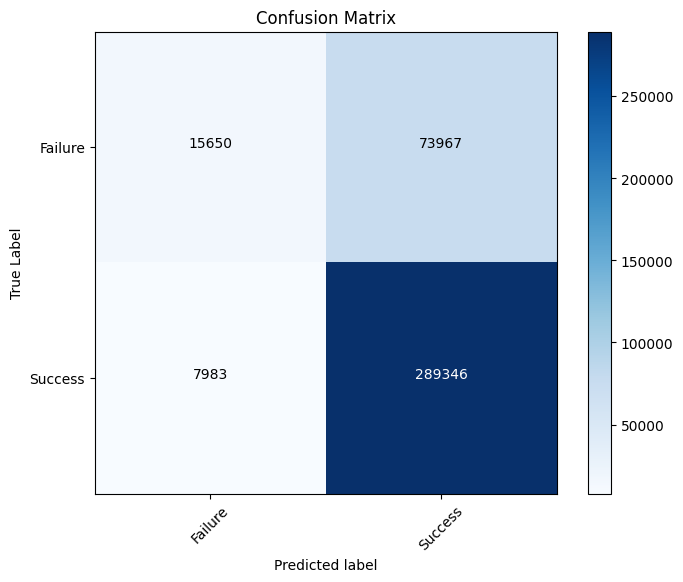

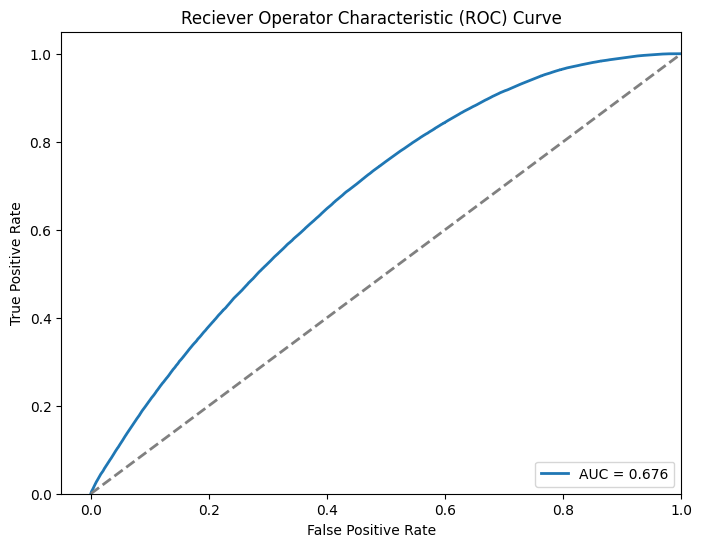

In [12]:
evaluate_classifier(train_pred_catboost, y_train, train_pred_prob_catboost)

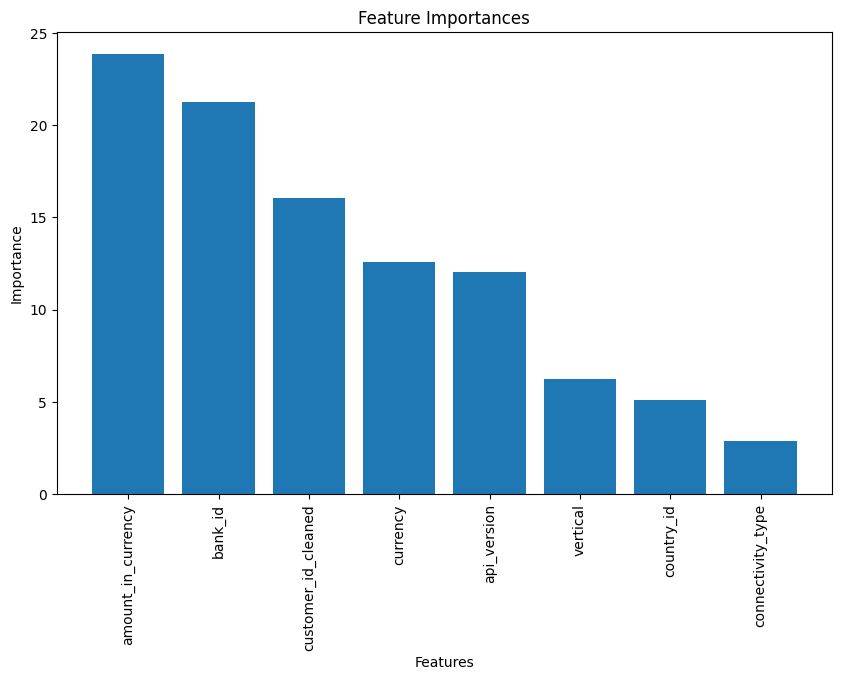

In [13]:
feature_importances = catboost_model.feature_importances_
feature_names = x_train.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### Testing Results


              precision    recall  f1-score   support

     Failure       0.65      0.17      0.27     22404
     Success       0.80      0.97      0.88     74333

    accuracy                           0.79     96737
   macro avg       0.72      0.57      0.57     96737
weighted avg       0.76      0.79      0.74     96737

No Information Rate: 0.77


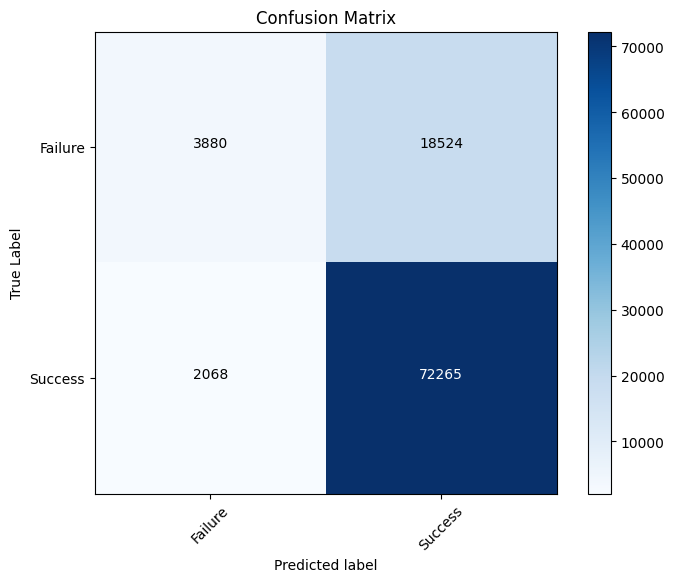

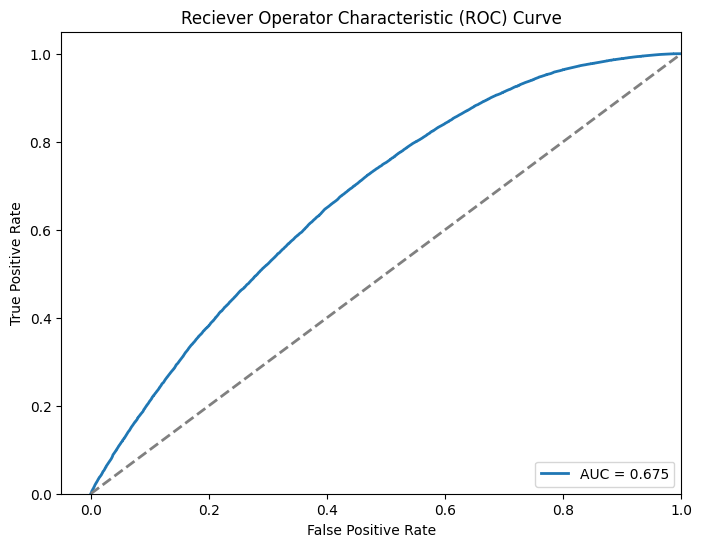

In [14]:
evaluate_classifier(test_pred_catboost, y_test, test_pred_prob_catboost)

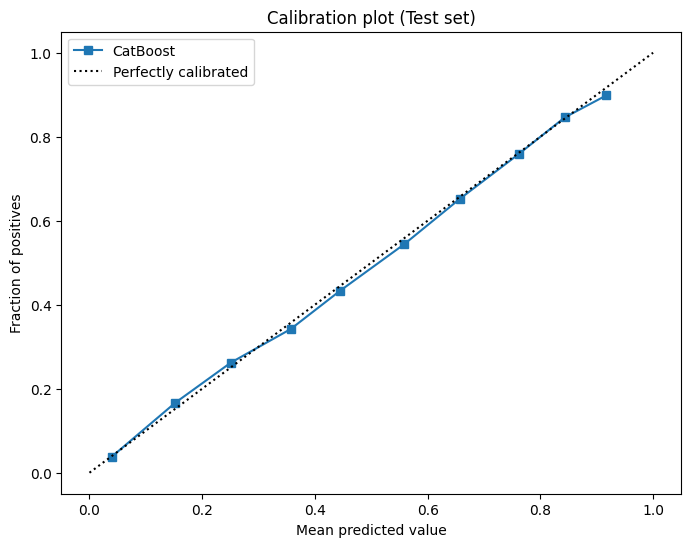

In [15]:
# Get predicted probabilities for the positive class
y_prob = test_pred_prob_catboost[:, 1]

# Calculate the calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="CatBoost")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.title("Calibration plot (Test set)")
plt.legend()
plt.show()


### Save Model Artifacts

In [16]:
# save
with open('/content/drive/MyDrive/truelayer/catboost_model.pkl', 'wb') as f:
    pickle.dump(catboost_model, f)
